In [1]:
from keras.models import Sequential
from keras.layers import Dense, LeakyReLU
import numpy as np
import matplotlib.pyplot as plt

def define_discriminator(inputs = 30000):
    ''' function to return the compiled discriminator model'''
    model = Sequential()
    model.add(Dense(25, activation = 'relu', kernel_initializer = 'he_uniform', input_dim = inputs))
    model.add(LeakyReLU(alpha = 0.01))
    model.add(Dense(15, activation = 'relu', kernel_initializer = 'he_uniform'))
    model.add(LeakyReLU(alpha = 0.01))
    model.add(Dense(5, activation = 'relu', kernel_initializer = 'he_uniform'))
    model.add(LeakyReLU(alpha = 0.01))
    model.add(Dense(1, activation = 'sigmoid'))
    model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
    return model

discriminator_model = define_discriminator()

2022-04-30 17:37:35.176203: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
def define_generator(latent_dim, outputs = 30000):
    model = Sequential()
    model.add(Dense(25, activation = 'relu', kernel_initializer= 'he_uniform', input_dim = latent_dim))
    model.add(LeakyReLU(alpha = 0.01))
    model.add(Dense(15, activation = 'relu', kernel_initializer = 'he_uniform'))
    model.add(LeakyReLU(alpha = 0.01))
    model.add(Dense(outputs, activation = 'linear'))
    return model

latent_dim = 5  # TODO: test different latent dims
generator_model = define_generator(latent_dim)

In [3]:
def define_gan(generator, discriminator):
    '''define the combined generator and discriminator model'''
    discriminator.trainable = False
    model = Sequential()
    model.add(generator)
    model.add(discriminator)
    model.compile(optimizer = 'adam', loss = 'binary_crossentropy')
    return model

gan_model = define_gan(generator_model, discriminator_model)

In [4]:
from preprocessing import loadData

data = loadData()

In [5]:
def generate_real_samples(n):
    '''generate a batch of real samples'''
    # choose random instances
    ix = np.random.randint(0, data.shape[0], n)
    # retrieve selected rows
    X = data[ix]
    # generate 'real' class labels (1)
    y = np.ones((n, 1))
    return X, y

def generate_fake_samples(generator, latent_dim, n):
    '''generate a batch of fake samples'''
    # generate points in latent space
    z = np.random.normal(0, 1, (n, latent_dim))
    # generate 'fake' class labels (0)
    y = np.zeros((n, 1))
    X = generator.predict(z)
    return X, y

def generate_latent_points(latent_dim, n):
    '''generate points in latent space'''
    # generate points in latent space
    z = np.random.normal(0, 1, (n, latent_dim))
    return z

def summarize_performance(epoch, generator, discriminator, latent_dim, n = 100):
    '''evaluate the discriminator and plot real and fake samples'''
    x_real, y_real = generate_real_samples(n)      #generate real samples
    _, acc_real = discriminator.evaluate(x_real, y_real, verbose = 1)
    x_fake, y_fake = generate_fake_samples(generator, latent_dim, n)
    _, acc_fake = discriminator.evaluate(x_fake, y_fake, verbose = 1)
    print('Epoch: ' + str(epoch) + ' Real Acc.: ' + str(acc_real) + ' Fake Acc.: '+ str(acc_fake))
    plt.scatter(x_real[:,0], x_real[:,1], color = 'red')
    plt.scatter(x_fake[:,0], x_fake[:,1], color = 'blue')
    plt.show()

In [6]:
def train_gan(g_model,d_model,gan_model,latent_dim, num_epochs = 10000,num_eval = 2000, batch_size = 128):
    half_batch = int(batch_size/2)
    for i in range(num_epochs):
        X_real, y_real = generate_real_samples(half_batch)
        d_model.train_on_batch(X_real, y_real)
        X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
        d_model.train_on_batch(X_fake, y_fake)
        #prepare points in latent space as input for the generator
        x_gan = generate_latent_points(latent_dim, batch_size)
        #generate fake labels for gan
        y_gan = np.ones((batch_size, 1))
        gan_model.train_on_batch(x_gan, y_gan)
        if (i+1) % num_eval == 0:
            summarize_performance(i + 1, g_model, d_model, latent_dim)

4/4 [==============================] - 0s 5ms/step - loss: 0.1673 - accuracy: 1.0000
Epoch: 2000 Real Acc.: 0.8899999856948853 Fake Acc.: 1.0


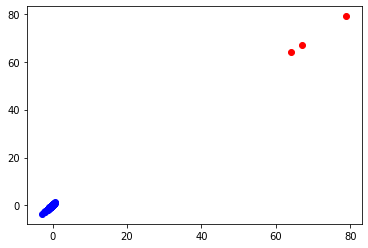

4/4 [==============================] - 0s 4ms/step - loss: 0.1576 - accuracy: 1.0000
Epoch: 4000 Real Acc.: 0.03999999910593033 Fake Acc.: 1.0


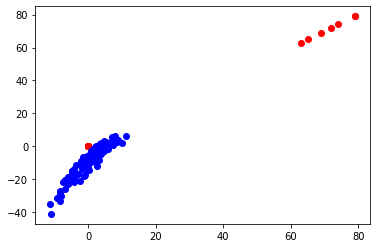

4/4 [==============================] - 0s 6ms/step - loss: 0.1079 - accuracy: 1.0000
Epoch: 6000 Real Acc.: 0.949999988079071 Fake Acc.: 1.0


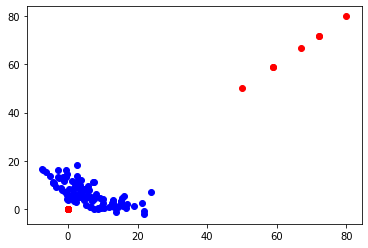

4/4 [==============================] - 0s 6ms/step - loss: 0.3769 - accuracy: 1.0000
Epoch: 8000 Real Acc.: 0.07999999821186066 Fake Acc.: 1.0


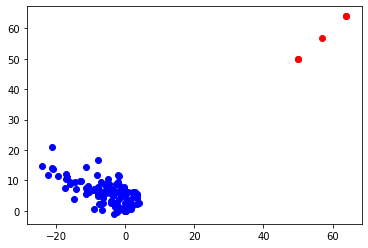

4/4 [==============================] - 0s 7ms/step - loss: 0.6065 - accuracy: 1.0000
Epoch: 10000 Real Acc.: 0.07000000029802322 Fake Acc.: 1.0


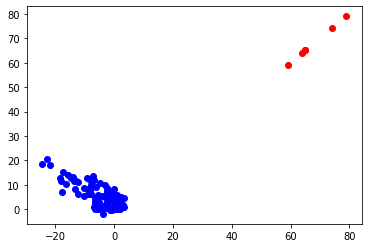

In [7]:
train_gan(generator_model, discriminator_model, gan_model, latent_dim)